Pattern Recognition 2019 - 2020: Lab 1
==========================
### Christos Lamprakos, 03002910

This document serves as report for the first lab exercise of the course.
> Due to an extremely hasty submission of the pre-lab work and ~~probably OCD-related~~ personal high-quality standards, all questions will be answered again here.

All code produced, along with the report itself, have been uploaded in a relevant GitHub [repo][0].

## Initializations
The code below performs all necessary imports for the rest of the project:

[0]: <https://github.com/cappadokes/patrec19/tree/master/labOne>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
import config
from src import datautilus
from src.euclidean_classifier import EuclideanClassifier
from mlxtend.plotting import plot_decision_regions

- plt: for plots.
- numpy: for data representation.
- cross_validate: for the same-named procedure.
- config: initializes a very simplistic class which contains information for where the data is stored.
- src: encloses all code (basically me trying to give the whole project a look it doesn't deserve).
- datautilus: contains all data manipulation-related methods. More info upon each method will be given once it's called for the first time.
- euclidean_classifier: module containing a fleshed-out version of the code outlined [here][1].
> if time permits, I would **REALLY** like to inject Seaborn in my picturing techniques. But now I'm hasty.
>- PCA: for the dimensionality reduction required by question 13b.
> also, is there a way to provide in-document links? If time permits...

[1]: <https://gist.github.com/georgepar/b53c01466d6649c8583497d120b9b479>

In [2]:
dataHouse = config.ToolConfig ()

The above variable just invokes the constructor for the simplistic ToolConfig class, which has the following definition:

```python
class ToolConfig ():
    def __init__ (self):
        self.train = './data/train.txt'
        self.test = './data/test.txt'
        self.save = './results/'
```
>Maybe the *save* part is not needed. All results can be produced in the notebook itself.

## Step 1
The format of choice for representing our data is numpy arrays. Thus a convenient way to read the files is via loadtxt. Since both the samples and their labels co-exist in the .txt's, array slicing is used for differentiating.:

```python
def dataReader (train_path, test_path):
    """
    Reads data.
    """
    train_concat = np.loadtxt (train_path)
    test_concat = np.loadtxt (test_path)
    """
    For convenience, the labels are turned 
    from floats to int.
    """
    y_train = train_concat[:, 0].astype (int)
    X_train = train_concat[:, 1:]
    y_test = test_concat[:, 0].astype (int)
    X_test = test_concat[:, 1:]
    return X_train, X_test, y_train, y_test
```

In [3]:
X_train, X_test, y_train, y_test = datautilus.dataReader (dataHouse.train,
                                                          dataHouse.test)

As may be observed, the notebook provides the **dataReader** method with the attributes of **dataHouse**, which are then used for locating the files.

## Step 2
For picking individual samples and their corresponding labels through a given index, the following method was implemented:

```python
def pickDigit (features, patterns, index):
    """
    Returns sample correspoinding to given index.
    """
    true_idx = index-1
    ind_feats = features[true_idx, :]
    ind_id = patterns[true_idx]
    return ind_feats, ind_id
```
> ***ASSUMPTION***: Indexes in the exercise description are **NOT** 0-based. Thus the samples' actual location in the arrays will always be assumed to be the given index minus 1.

To illustrate the picked digit as an image, the following methods were implemented:

```python
def printSingleDigit (feature):
    """
    Plots a single sample.
    """
    fig, axs = plt.subplots ()
    axs, im = digit2Fig (feature, axs)
    fig.colorbar (im)
    axs.set_ylabel ('pixel no.')
    axs.set_xlabel ('pixel no.')
    plt.show ()

def digit2Fig(feature, ax):
    """
    Returns an axes object (for sub-plotting).
    """
    transformed = np.reshape (feature, (16, 16))
    im = ax.imshow (transformed, cmap = 'gist_yarg')
    return ax, im
```
Admittedly, a simpler implementation could have been followed.

As advised in the exercise description, NumPy's **reshape** method was used to pixelize the flat-indexed sample features. A colormap reminiscing of black ink on white paper was chosen for naturalness.

Thus it's time to isolate digit #131:

Picking pattern #131...
Done! Number is  0 
Printing...


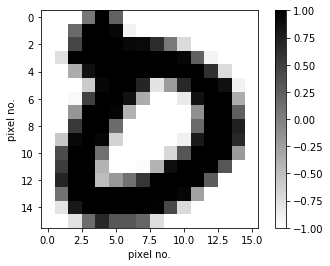

In [4]:
print ('Picking pattern #131...')
feat_131, id_131 = datautilus.pickDigit (X_train, y_train, 131)
print ('Done! Number is ', id_131, '\nPrinting...')

datautilus.printSingleDigit (feat_131)

...well, this doesn't look like a 0. But utter trust is put upon the label-producing procedure.

## Step 3
First, the following method was written to locate the indices of all samples labelled with a certain value:

```python
def findDigit (features, patterns, value):
    """
    Returns all samples labelled with given value.
    """
    indexes = np.nonzero (patterns == value)[0]
    return features[indexes, :]
```
Numpy's [nonzero][nz] method was used for generating the indices.

Consequently, the above method can be combined with **subplot** and previously-introduced **digit2Fig** to produce the 10 figures requested.

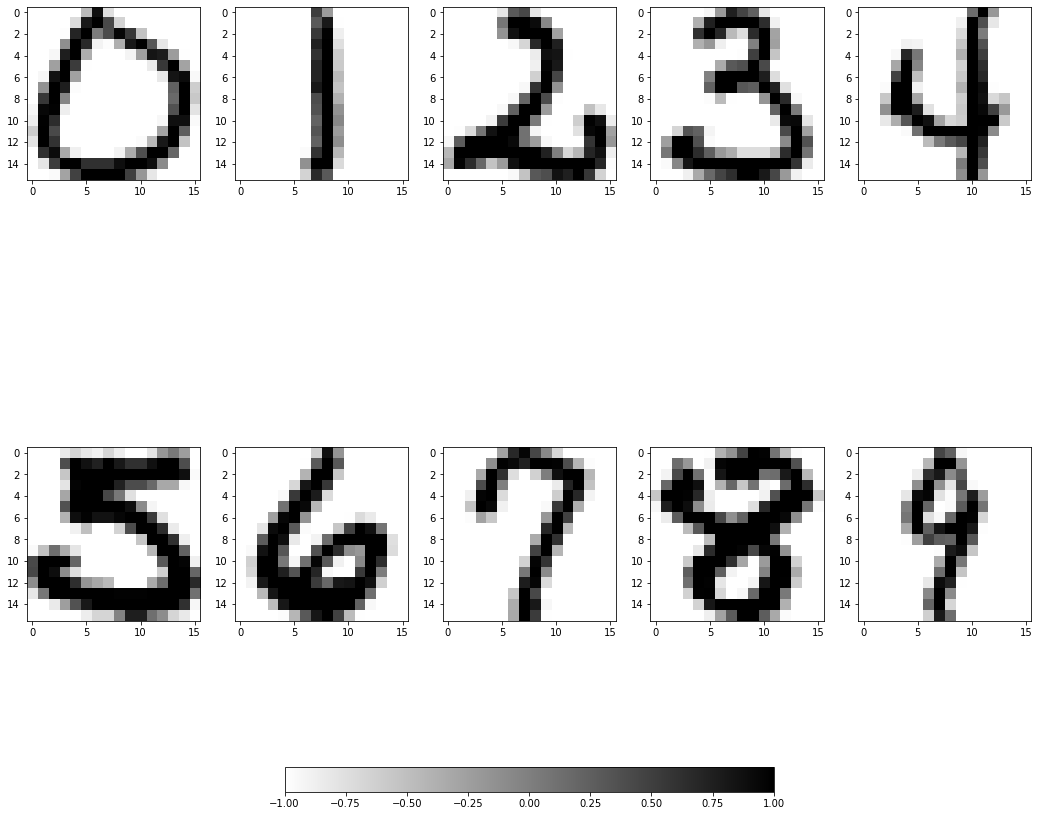

In [5]:
step3_fig, axs3 = plt.subplots (2, 5, figsize = (18, 18))
#This is a very bad scheme to keep track of the subplots.
posx, posy = 0, 0
for num in range(10):
        step3_num = datautilus.findDigit (X_train, y_train, num)[0, :]
        axs3[posx, posy], im3 = datautilus.digit2Fig (step3_num,
                                                      axs3[posx, posy])
        #posx, posy only serve the subplots' indexing, and could
        #undoubtedly be generated more efficiently...
        posy += 1
        if posy % 5 == 0:
            posy = 0
            posx += 1
step3_fig.colorbar (im3, ax = axs3, orientation = 'horizontal',
                    fraction = .025)
plt.show()

## Steps 4-8
The following method was written to accomodate mean and variance calculations (which were performed through NumPy's ready-to-use array attributes **mean** and **var**):

```python
def analyzeDigit (features, patterns, value):
    """
    Computes mean and variance values for all pixels (features)
    of the digit denoted by input variable 'value'. Also plots mean
    and variance side-by-side.
    """
    feats_val = findDigit (features, patterns, value)
    mean_val = feats_val.mean (axis = 0)
    var_val = feats_val.var (axis = 0)
    [fig, axs] = plt.subplots (1, 2, squeeze = False,
                                        figsize = (18, 18))
    return mean_val, var_val
```
>**Reminder:** findDigit returns all samples labelled with a given value!

So when invoked, mean and variance is calculated for **all** pixels of a digit. To specifically refer to pixel (10, 10), the following formula was employed:

```python
flat_idx = (posx - 1) * 16 + (posy - 1)
```
To print the means and the variances, the already-described **printSingleDigit** method was used. 

The code producing the desired output is thus:

For digit 0, mean value of pixel (10, 10) is  -0.927264656616415
For digit 0, variance of pixel (10, 10) is  0.08392455977261963


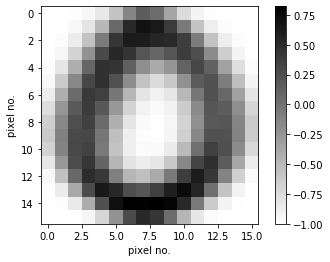

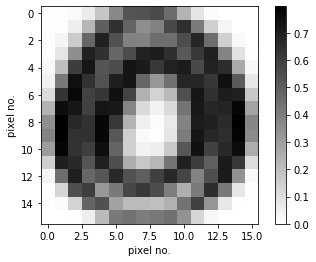

In [6]:
mean_0, var_0 = datautilus.analyzeDigit (X_train, y_train, 0)
flat_idx = 9 * 16 + 9
print ('For digit 0, mean value of pixel (10, 10) is ',
       mean_0[flat_idx])
print ('For digit 0, variance of pixel (10, 10) is ',
       var_0[flat_idx])
datautilus.printSingleDigit (mean_0)
datautilus.printSingleDigit (var_0)

The following points can be made for the above results:
* the shape of the digit has indeed been preserved in both figures. This shows that people actually abide to universal rules in their handwriting, and these rules can in turn be encoded (with some loss) in the features' mean values.
* pixels with high mean value demonstrate low variance, while pixels with low mean value demonstrate high variance.
    - high mean value denotes universally common parts of the digit.
    - high variance denotes 'creative freedom'. Many paths on the grid could have been chosen. The mean is spread, less concentrated.
    - **maybe** high mean/low variance pixels could represent the dominant features of each digit, thus providing a first hint to dimensionality reduction...
* the pixels with the highest mean (and lowest variance) are located at the top point and bottom curve of the digit. This can be explained in the following way:
    - most people start plotting a '0' from the top (universality, high mean). 
    - then, depending on a variety of factors, they continue either clock- or counterclockwise, and they also give the circle a variety of widths (creativity, high variance both in the inner and the outer rings)
    - finally, all circles eventually close. The bottom curve seems even more universal than the top point.

## Step 9
Means and variances over all pixels of all patterns were calculated by using the methods demonstrated above. A **for** loop repeatedly invoked **analyzeDigit**, each time stacking the resulting arrays over the ones already calculated.

> By opting for this 'stacked' representation of means in a (10, 256) ndarray, the potential for vectorized implementation is preserved.

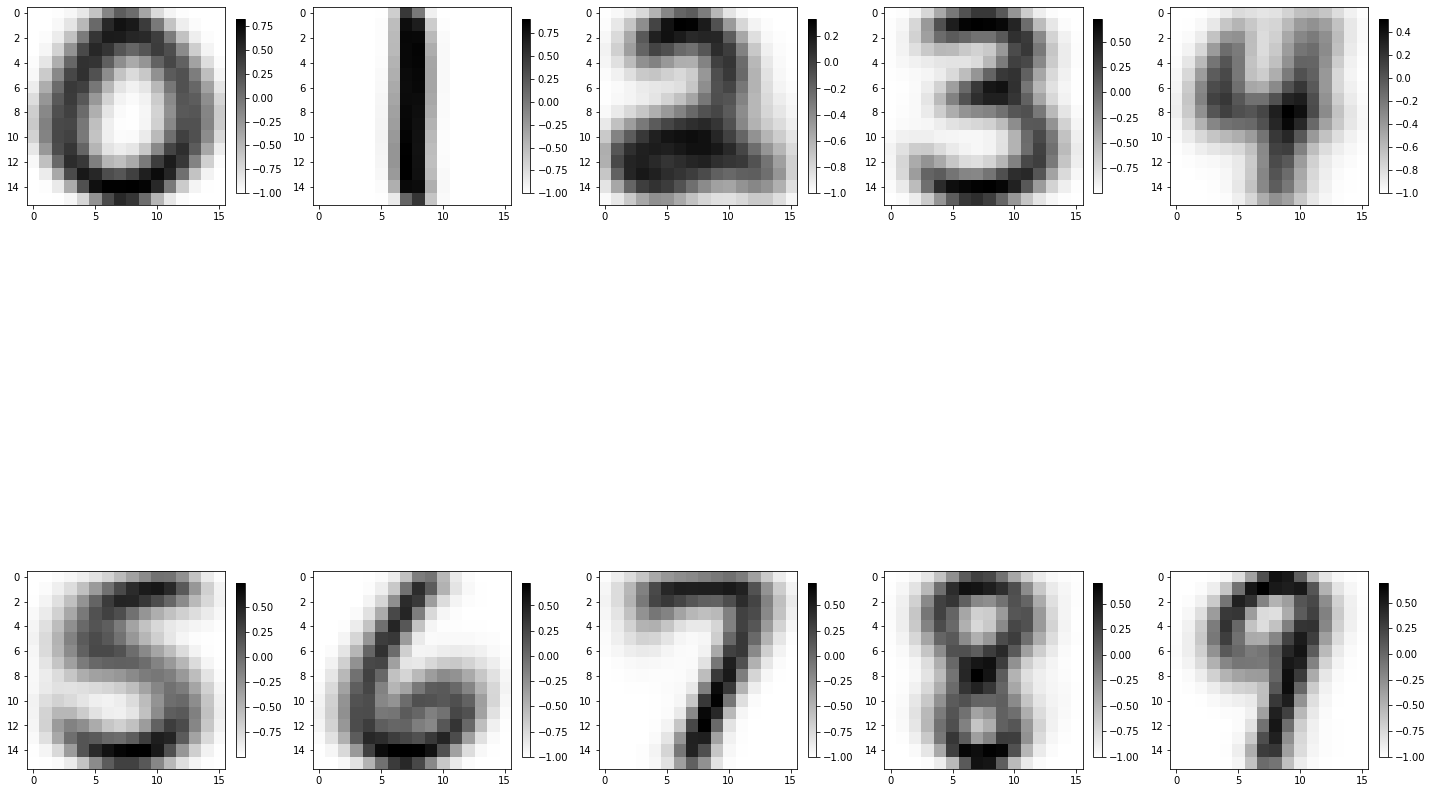

In [7]:
step9_fig, axs9 = plt.subplots (2, 5, figsize = (20, 20))
posx, posy = 0, 0
for num in range(10):
        mean_num, var_num = datautilus.analyzeDigit (X_train, y_train, num)
        if num == 0:
            means_overall = mean_num
            vars_overall = var_num
        else:
            means_overall = np.vstack ((means_overall, mean_num))
            vars_overall = np.vstack ((vars_overall, var_num))
        axs9[posx, posy], im9 = datautilus.digit2Fig (mean_num,
                                                      axs9[posx, posy])
        step9_fig.colorbar (im9, ax = axs9[posx, posy], fraction = .04)
        posy += 1
        if posy % 5 == 0:
            posy = 0
            posx += 1
step9_fig.tight_layout ()
plt.show ()

What was observed in Step 8 is now found to hold for all 10 digits. Universality of digit parts is translated to high mean values (the straight line of '1', the crossing middle point of '4', the top and bottom of a '3' or an '8'). Shapes have, in general, been preserved.

> ***HYPOTHESIS***: A classifier which uses these mean values as knowledge can **not** perform that bad...

## Step 10
The 101th sample was picked from the train dataset using **pickDigit**. The following method (more of a simple wrapper for a scikit-learn module) was implemented:

```python
def askEuclid (knowledge, feature):
    """
    Classifies a single sample based on euclidean distance.
    """
    dists = euclidean_distances (knowledge, [feature])
    return np.array (dists).argmin ()
```

By using the **argmin** attribute of NumPy arrays, the label corresponding to the minimum euclidean distance is retrieved.

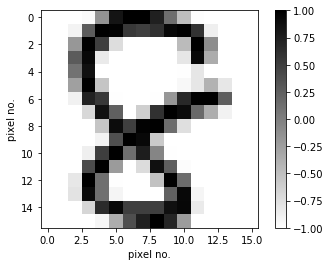

prediction:  8
actual:  8


In [8]:
feat_101, id_101 = datautilus.pickDigit (X_train, y_train, 101)
pred_101 = datautilus.askEuclid (means_overall, feat_101)
datautilus.printSingleDigit (feat_101)
print ('prediction: ', pred_101)
print ('actual: ', int (id_101))

Prediction was correct! This is in accordance to the hypothesis stated in the previous step.

## Step 11
With a vectorized implementation in mind, it is time to utilize the **means_overall** ndarray which was calculated during Step 9:

```python
def batchEuclid (features, patterns, knowledge):
    """
    Classifies whole dataset via euclidean distance. Returns score.
    """
    dists = euclidean_distances (knowledge, features)
    preds = np.array (dists).argmin (axis = 0)
    truthVector = (preds.T.astype (float) == patterns)
    pos = truthVector.sum ()
    score = pos / features.shape[0] * 100
    return score
```

In [9]:
score = datautilus.batchEuclid (X_test, y_test, means_overall)
print ('The trained Euclidean classifier performed ', score,
       'successfully on the test dataset.')

The trained Euclidean classifier performed  81.41504733432984 successfully on the test dataset.


Thus, the hypothesis regarding more-than-mediocre performance of the classifier is backed from the test data. **However**, this could be a case of bias due to uneven split between training and test data, and we cannot be sure until cross-validation is applied.

> Still, 81% is impressive, considering the simplicity of the decision process.

## Step 12
As per the exercise description, [this][1] code was used as an outline. The fleshed-out version used in this notebook can be found [here][2]. The **predict** and **score** methods are merely a segmentation of **batchEuclid**, described above. Due to its importance, you may find below the **fit** method transcribed below:

```python
def fit(self, X, y):
        """
        Calculates self.X_mean_ based on the mean
        feature values in X for each class.
        """
        for i in range (10):
            feats_val = datautilus.findDigit (X, y, i)
            mean_val = feats_val.mean (axis = 0)
            if i == 0:
                self.X_mean = mean_val
            else:
                self.X_mean = np.vstack((self.X_mean, mean_val))
        return self
```

To ensure that no bugs exist up until this point, some of the previous questions were repeated, this time employing the scikit-learn estimator:

[2]: <https://github.com/cappadokes/patrec19/blob/master/labOne/src/euclidean_classifier.py>
[1]: <https://gist.github.com/georgepar/b53c01466d6649c8583497d120b9b479>

In [10]:
lilEuclid = EuclideanClassifier ()
print ('Euclidean classifier initialized. Now fitting on test data...')
lilEuclid.fit (X_train, y_train)
pred_101_sk = lilEuclid.predict ([feat_101])
print ('The scikit-learn EC classifies sample #101 as: ', pred_101_sk)
score_sk = lilEuclid.score (X_test, y_test)
print ('Also, its score on test data is: ', score_sk)

Euclidean classifier initialized. Now fitting on test data...
The scikit-learn EC classifies sample #101 as:  [8]
Also, its score on test data is:  81.41504733432984


## Step 13
For the cross validation, the existing sklearn **cross_validate** method will be utilized. For this to happen, the following steps must be taken:
- the train and test datasets and labels should be merged.
- a new EuclideanClassifier object should be initialized.

In [11]:
X_total = np.vstack((X_train, X_test))
y_total = np.concatenate((y_train, y_test))
print ('Datasets joined!')
euclidClf = EuclideanClassifier ()
print ('Ready to cross_validate!')
cv_results = cross_validate (euclidClf, X_total, y_total, cv = 5)
print ('CV-complete: ', cv_results)

Datasets joined!
Ready to cross_validate!
CV-complete:  {'fit_time': array([0.0129621 , 0.01193142, 0.0096705 , 0.01190019, 0.00953698]), 'score_time': array([0.00125599, 0.00097966, 0.00096655, 0.0009408 , 0.00096297]), 'test_score': array([85.35407725, 84.42534909, 84.94623656, 84.28417653, 81.87702265])}


The cross validation output implies the following:
- the methods of the classifier demonstrate acceptable fit and training times (which are however platform-dependent and thus not entirely indicative of computational complexity).
- performance remains steadily over **80%** in all 5 folds. Thus it is indeed a decent baseline classifier, against which more complex approaches could be compared.

As regards the decision boundary, it cannot be plotted with the data in this multidimensional state. Principal component analysis (PCA) was used for dimensionality reduction to 2 dimensions. Also the external library [mlxtend][3] was used for plotting the decision region.

> **ASSUMPTION**: The decision boundary is requested for the test data, on the case of a euclidean classifier trained on the train data.

[3]: <https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/>

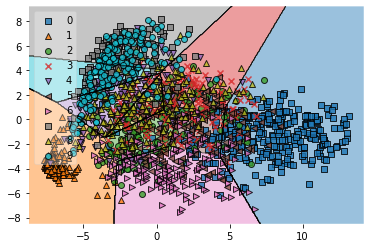

In [12]:
PCA_obj = PCA (n_components = 2)
X_train_reduced = PCA_obj.fit_transform (X_train)
X_test_reduced = PCA_obj.fit_transform (X_test)
pcaEuclid = EuclideanClassifier ()
pcaEuclid.fit (X_train_reduced, y_train)
plot_decision_regions (X_test_reduced, y_test, clf = pcaEuclid, legend = 2)
plt.show ()

The above result has mostly intuitive value, since it does not accurately resemble the classifier we have been building up to this point. Huge overlap is noted between samples from almost all classes (with the exception of '0', '1' and maybe '6'). The decision regions do not seem to capture the essence of the classes. All this is expected, since an immense dimensionality reduction has taken place.

What could maybe be derived from this figure is a sense of inadequacy of the euclidean classifier to achieve respectable performance in the particular problem. However, the decent baseline stats that the cross validation gave are **not** visible here.

Finally, for the learning curve, NumPy's [**learning_curve**][4] method was used. Then the returned statistics were processed and visualized according to [this][5] example.

[5]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
[4]: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html>

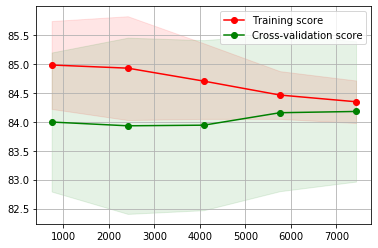

In [13]:
euclidClf = EuclideanClassifier ()
train_sizes, train_scores, test_scores = learning_curve (euclidClf, X_total, y_total, cv = 5, shuffle = True, random_state = 62)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show ()

The following points are worth noting on the above result:
- *Training score*: denotes the performance of the classifier on training data of various sizes, after training on **that same** data.
    * the score worsens as the size increases. This makes sense. After all, the classifier decides based on the dataset's mean features. With an ever greater population, these features become weaker and weaker: more people means more creativity, which translates to greater variance of the data.
    * the score's standard deviation decreases as the size increases. This happens for the same reason as above. With all the greater variance, it becomes more and more statistically certain that the classifier will underperform.
- *Cross-validation score*: denotes the classifier's performance on **unseen** test data, after training on training data of various sizes and achieving the respective training score.
    * the training set size has no impact on the--large--standard deviation. This also makes sense, and indicates the inability of the mean to 'adapt'. 
    * the performance is clearly better in the case of a large training set. Unsurprisingly, more knowledge leads to more protection against the unknown. 